In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('once')
from sklearn.tree import DecisionTreeRegressor
import datetime as dt

In [2]:
df = pd.read_csv('../datos/registrados/05-registrados_encoding.csv', index_col=0)
df.head(2)

,dteday,season,yr,mnth,holiday,weekday,weathersit,atemp,hum,windspeed,registered
0,2018-01-01,0,0,0,0,0,1,18.18125,80.5833,10.749882,654
1,2018-01-02,0,0,0,1,1,1,17.68695,69.6087,16.652113,670


Cambiamos los tipos de dato en las columnas holiday y weathersit para que pueda realizar el decision tree.

In [3]:
df = df.astype({'holiday': 'int64', 'weathersit': 'int64'})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   atemp       730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  registered  730 non-null    int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 68.4+ KB


Eliminamos columnas redundantes

In [5]:
df.drop(['dteday','yr'],axis = 1, inplace =True)

In [6]:
df.head(2)

,season,mnth,holiday,weekday,weathersit,atemp,hum,windspeed,registered
0,0,0,0,0,1,18.18125,80.5833,10.749882,654
1,0,0,1,1,1,17.68695,69.6087,16.652113,670


# Guardamos 

In [7]:
df.to_csv('../datos/registrados/08-registrados-NO-esta-encoding.csv')

---

In [8]:
X = df.drop("registered", axis = 1)
y = df["registered"]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

In [10]:
arbol = DecisionTreeRegressor(random_state =0)
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

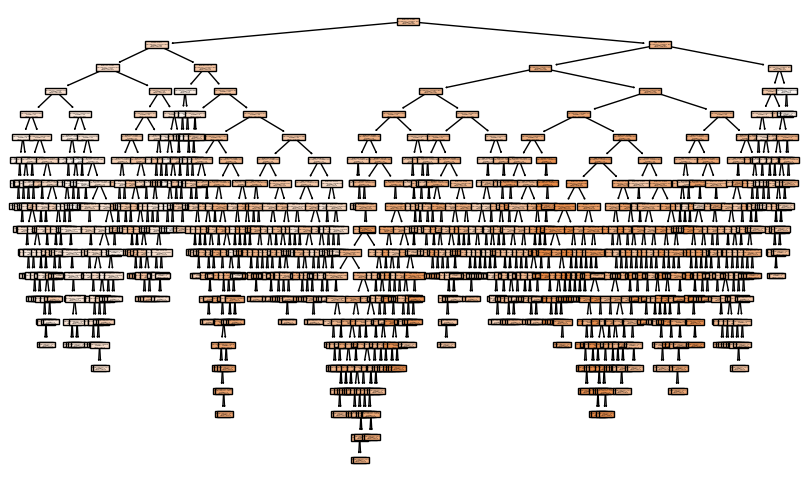

In [13]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

In [11]:
max_features = np.sqrt(len(x_train.columns))
max_features

2.8284271247461903

In [12]:
print(arbol.tree_.max_depth)

18


In [13]:
param = {"max_depth": [2,4,6,8,],
        "max_features": [1,2,3],
        "min_samples_split": [10,40,70],
        "min_samples_leaf": [10,40,70]} 

In [14]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error")
gs.fit(x_train, y_train)



GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 40, 70],
                         'min_samples_split': [10, 40, 70]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [15]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=8, max_features=3, min_samples_leaf=10,
                      min_samples_split=70)

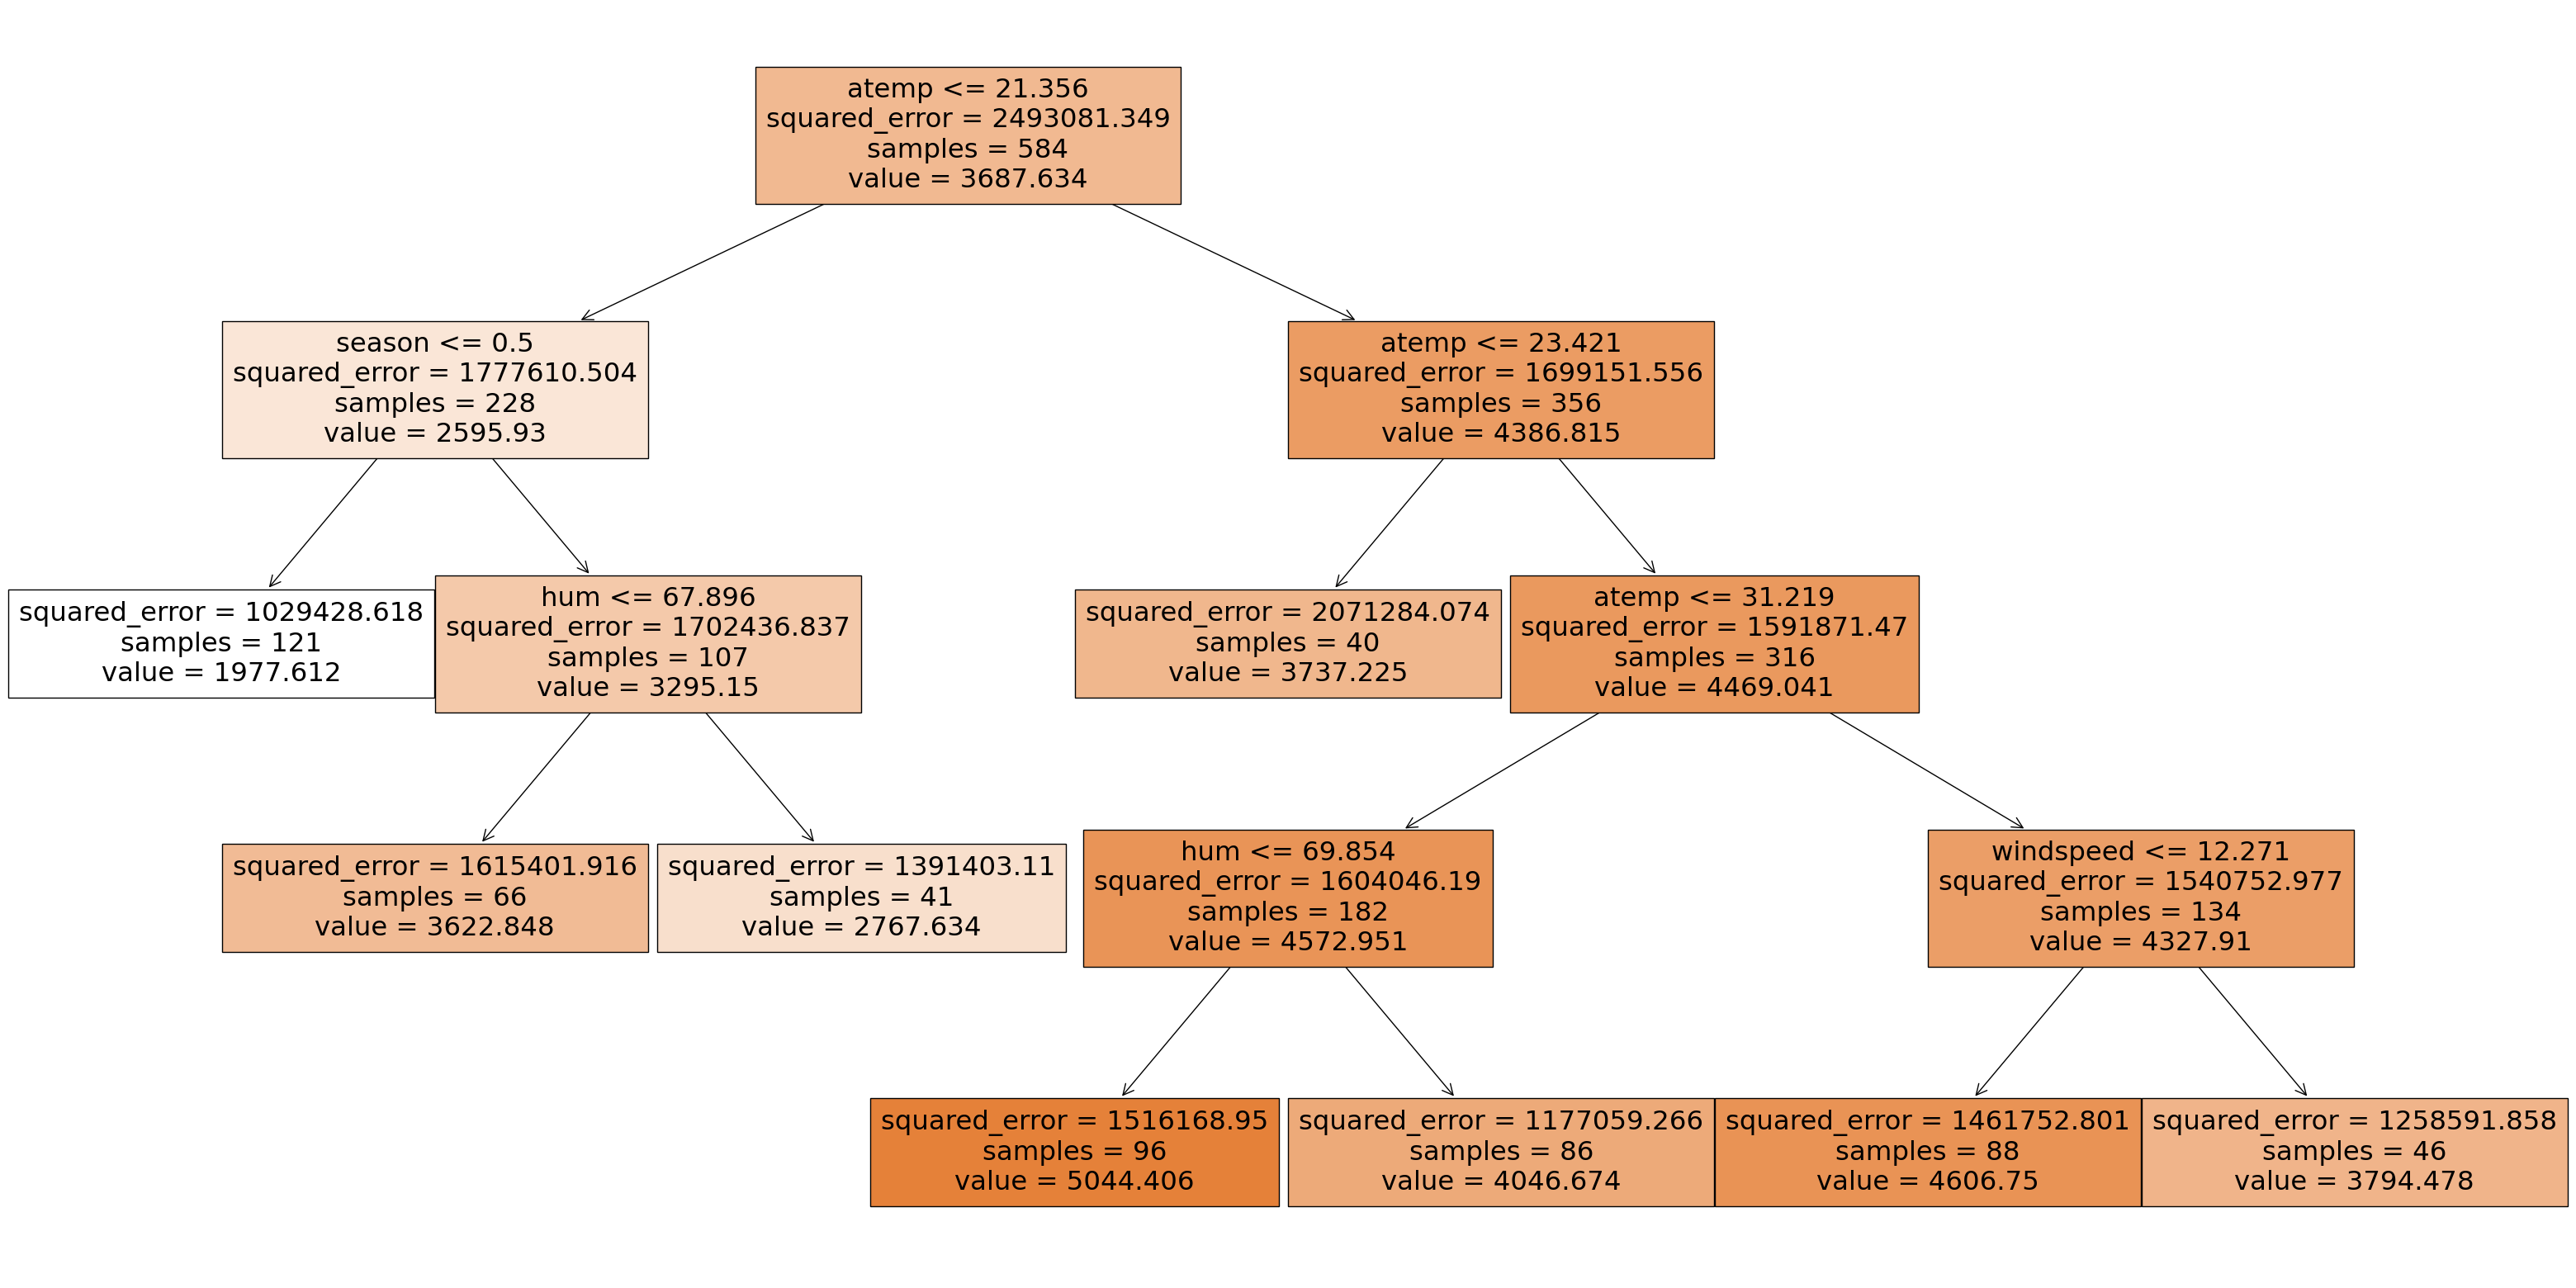

In [19]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [16]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [17]:

def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [18]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "1_Decision_tree_sin_estandar")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,1027.099677,1.566425e+06,1251.568963,0.274323,test,1_Decision_tree_sin_estandar
1,936.879987,1.270523e+06,1127.174582,0.490381,train,1_Decision_tree_sin_estandar


Random forest

In [19]:
X = df.drop("registered", axis = 1)
y = df["registered"]

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [21]:
param = {"max_depth": [2,4,6,8,10],
        "max_features": [1,2,3],
        "min_samples_split": [10,40,70],
        "min_samples_leaf": [10,40,70]} 

In [22]:
gs_rf = GridSearchCV(
            estimator=RandomForestRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 


In [23]:
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 40, 70],
                         'min_samples_split': [10, 40, 70]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [24]:
bosque = gs_rf.best_estimator_
bosque

RandomForestRegressor(max_depth=8, max_features=3, min_samples_leaf=10,
                      min_samples_split=10)

In [29]:
'''for arbol in tqdm(bosque.estimators_):
    fig = plt.figure(figsize=(40, 20))
    tree.plot_tree(arbol, feature_names= x_train.columns, filled = True)
    plt.show()'''

'for arbol in tqdm(bosque.estimators_):\n    fig = plt.figure(figsize=(40, 20))\n    tree.plot_tree(arbol, feature_names= x_train.columns, filled = True)\n    plt.show()'

In [25]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
   
   
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df


In [26]:
dt_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "1Random Forest_sin_estandar")
dt_results

,MAE,MSE,RMSE,R2,set,modelo
0,928.338647,1.112348e+06,1054.679327,0.484683,test,1Random Forest_sin_estandar
1,841.066666,9.698471e+05,984.808152,0.610985,train,1Random Forest_sin_estandar


In [27]:
df_todos_resultados = pd.concat([dt_results, dt_results1], axis = 0)
df_todos_resultados


,MAE,MSE,RMSE,R2,set,modelo
0,928.338647,1.112348e+06,1054.679327,0.484683,test,1Random Forest_sin_estandar
1,841.066666,9.698471e+05,984.808152,0.610985,train,1Random Forest_sin_estandar
0,1027.099677,1.566425e+06,1251.568963,0.274323,test,1_Decision_tree_sin_estandar
1,936.879987,1.270523e+06,1127.174582,0.490381,train,1_Decision_tree_sin_estandar


In [28]:
df_todos_resultados.to_csv('../datos/registrados/08_metricas_NO_estandar.csv')